# Vaccination (Demo)
In order to demonstrate the simulations, which were performed to evaluate the different vaccination-strategies in our [preprint](https://www.medrxiv.org/content/10.1101/2020.12.16.20248301v1), we generated a jupyter notebook. We suggest to get familiar with the `Demo.ipynb` notebook first, in order to get an intuition for our model and its basic application and characteristics.

This notebook subdivied the following code blocks:

1. ["Initiate world"](#buildW) - initialize small or large world for Gangelt (small = 10% of population and buildings, large = 100% of population and buildings)

2. [Simulating an initial infection-wave](#runIni) to be used in defining one of the tested strategies
	—> Be aware that here exists a checkpoint for the user 
    
3. [Define vaccination orders](#defOrder) for different vaccination strategies.

4. [Running simulations with different vaccination-fractions](#runVacScreen) of the population, for the different strategies.

5. [Generating a plot](#plots), resembling figure 3 in our manuscript.

Please be aware, that we set the default world to be used to the small version, in order to avoid excessive runtimes for this demonstration. 
Since this world is not fully representative to the large world, we used for the manuscript; the infection-dynamics differ and thus the results of the vaccintion-screens do too.
Furthermore we have set the vaccination-fraction increments to 20% (where we used 5%-steps in the manuscript), also to reduce runtime.

#### Be aware: Excessive Runtime!
The (default) reduced version of the vaccination screens has a runtime of around **1-2 hours**, but there exists the possibility to use the non-reduced version (as we did in the manuscript); however be aware, that we expect a runtime of **12-36 hours** for this.

In [1]:
from gerda.core.virusPropagationModel import *
import gerda.utilities.VPM_plotting as vpm_plot
%matplotlib inline
%load_ext autoreload
import glob
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
#%load_ext memory_profiler

In [2]:
import time
t0=time.time()

# Build world <a id='buildW'></a>

In [3]:
geopath = 'input_data/geo/'
geofiles = {
            0:'Buildings_Gangelt_MA_1.csv',
            1:'Buildings_Gangelt_MA_3.csv',
}         

### Choose which world to initate

Here we choose, which version of the world to use for the vaccination-screens in this notebook.
By default we use the reduced version of the world, in order to avoid excessive runtimes (reduced version approx. 2h, complete version approx. 12h).
However one can comment out the second line and uncomment the first line, to run the screen on the large world, we based the results in the manuscript on.

In [4]:
world_to_pick = 0 ## choosing complete version
# world_to_pick = 1 ## choosing reduced version

### Initiate the selected world without infections

In [5]:
n_initially_infected=0
modeledWorld = ModeledPopulatedWorld(initial_infections=n_initially_infected, geofile_name=geopath+geofiles[world_to_pick], input_schedules='schedules_v2')
n_people = modeledWorld.number_of_people
print('Number of agents: '+ str(n_people))

Number of agents: 10375


### Definition of the function to initially infect specified susceptible agents

All agents with IDs in the list 'IDs' will be initially infected

In [6]:
def infect_world(world, IDs=[1]):
    ID_list = world.get_remaining_possible_initial_infections(IDs)
    world.initialize_infection(specific_people_ids=ID_list)

# Run initial simulation<a id='runIni'></a>

Here we run an intitial (unperturbed) infection wave, to be used in the vaccination strategy which is based on the forecasted infection wave.

#### Define Simulation characteristics

timesteps_initial_sim: Number of simulated timesteps in hours for the initial simulation <br>
general_infectivity: Scaling factor for the general infectivity (default value = 0.3) <br>
general_interaction_frequency: Expected interaction-frequency over all individuals per hour (default-value=2/h)

In [7]:
timesteps_initial_sim=2500
general_infectivity=0.3
general_interaction_frequency=2

#### Introduce infected agents

Before starting the simulation the generated world is copied to ensure the same origin for each simulation. The number of initial infections is defined by 'n_initially_infected' (default=4).

In [8]:
world_to_use = copy.deepcopy(modeledWorld)

n_initially_infected=4+6

infect_world(world_to_use, IDs=[i+1 for i in range(n_initially_infected)])

amount of initially recovered agents: 0


#### Set up simulation with specified characteristics

In [9]:
simulation_initial_wave = Simulation(world_to_use, timesteps_initial_sim, run_immediately=False)

simulation_initial_wave.change_agent_attributes({'all':{'behaviour_as_infected':{'value':general_infectivity,'type':'replacement'}}})
simulation_initial_wave.interaction_frequency=general_interaction_frequency

#### Run simulation

In [10]:
simulation_initial_wave.simulate()

### CHECKPOINT FOR USER:

If the plot below does not show an infection outbreak (due to the stochastic nature of our model, some infection-waves may die out); please re-run the two cells above and continue if the plot shows an outbreak.

#### Plot status-trajectories

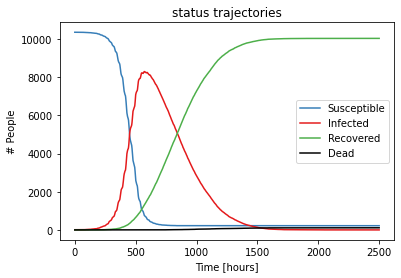

In [11]:
simulation_initial_wave.plot_status_timecourse()

# Define vaccination orders for different vaccination strategies <a id='defOrder'></a>

Vaccination orders are defined by ordered lists of agent IDs following specified sorting rules.
These are:
1. sorted by [forecasted infection wave](#sorted)
2. sorted by [overrepresentation](#overrep) of agent type in infection spreading
3. sorted by [agent interactivity](#activity)
4. sorted by [households](#house)
5. sorted by [age](#age) (descending)
6. sorted [randomly](#random)

## Sorting strategies, based on previous simulation

The following two vaccination strategies are based on results derived from predceeding simulations.

### 1. Sorted by forecasted infection wave <a id='sorted'></a>

Here we return the order, in which agents got infected in the previous simulation (simulation_initial_wave).
This gives us a vaccination-order, based on the simulated outbreak.

#### Define function to sort agents according to forecasted infection wave

In [12]:
def get_previous_infections(previous_simulation):
    df_inf = previous_simulation.get_infection_event_information()
    infected = list(df_inf['h_ID'].values)
    all_agents = infected+[a.ID for a in previous_simulation.people if a.ID not in infected]
    return all_agents

#### Create list of agents sorted by forecasted infection wave, by executing defined function

In [13]:
agents_forecasted = get_previous_infections(simulation_initial_wave)

### 2. Sorted by over-representation (agent types) <a id='overrep'></a>

Here we sort agents by the the number of infections caused, relative to the number of individuals of the respective type (termed over-representation). Order of individual agents of the repective is not specified.

#### Define function to sort agents by type. The sequence of types is defined in sorted list "agent_types". 

In [14]:
def get_ids_by_agent_type(world,agent_types_sorted_by_overrepresentation):
    ids_by_type = {s_type:[] for s_type in agent_types_sorted_by_overrepresentation}
    for p in world.people:
        ids_by_type[p.schedule['type']].append(p.ID)
    ordered_ids = []
    for s_type in agent_types_sorted_by_overrepresentation:
        ordered_ids.extend(ids_by_type[s_type])
    return ordered_ids

#### Create list of agents sorted by type, by executing defined function

Please note that the order of agent types, acording to over-representation, is not determined automatically in this notebook. Instead we used the order, applied in the manuscript and hard-coded it in the variable "agent_types_sorted_by_overrepresentation"

In [15]:
agent_types_sorted_by_overrepresentation = ['under_age', 'adult', 'teacher', 'medical_professional', 'public_worker', 'pensioner']
agents_by_type = get_ids_by_agent_type(modeledWorld,agent_types_sorted_by_overrepresentation=agent_types_sorted_by_overrepresentation)

### 3. Sorted by Interactivity <a id='activity'></a>

Here we sort agents, based on their "interactivity". This is determined by performing a preceding simulation of 168 hours (1 week), without any introduced infection (so the determining the interactivity is not affected by the infection-spread); and subsequntly sorting agents according to the number of interactions, they had.

#### Define function to sort agents with decreasing number of total interactions from a preceding simulation without infection spreading

In [16]:
def get_ids_by_interactions(simulation_no_infections):
    contacts = simulation_no_infections.get_contact_distributions(min_t=0, max_t=168)[1]
    contacts_mean = contacts.groupby('ID').mean()
    contacts_mean.reset_index(inplace=True)
    contacts_sorted = contacts_mean.sort_values('interactions', axis=0, ascending=False)
    to_recover_list = list(contacts_sorted['ID'].values)
    return to_recover_list

#### Run the preceding simulation without infection spreading

In [17]:
timesteps_blank_sim=168
uninfectedWorld = copy.deepcopy(modeledWorld)
simulation_no_infections = Simulation(uninfectedWorld, timesteps_blank_sim, run_immediately=False)
simulation_no_infections.interaction_frequency=general_interaction_frequency
simulation_no_infections.simulate()

#### Create the list of agents sorted by decreasing number of total interactions, by executing defined function

In [18]:
agents_by_interactions = get_ids_by_interactions(simulation_no_infections)

## Sorting-strategies, based on population-structure

The following strategies are based on the population structure of the simulated world and do not require preceeding simulations

### 4. Sorted by household <a id='house'></a>

Define function to sort agents by their households. First one member of each household is chosen. When there is one member for each household a second member is chosen for each household of size 2 and bigger. After that a third member is chosen for each household of size 3 and bigger. ...

In [19]:
def get_ids_by_households(world):
    ai = world.get_agent_info()
    home_count_dict = dict(zip(list(ai.groupby('Home').count().index), list(ai.groupby('Home').count()['ID'])))
    ai['Home_size']=ai['Home'].map(home_count_dict)

    ai_sorted = ai.sort_values('Home')
    home_list = ai_sorted['Home'].values

    count_list=[]
    predecessor = 0
    count = 1
    for x in home_list:
        if x == predecessor:
            count +=1
        else:
            count = 1
        count_list.append(count)
        predecessor = x

    ai_sorted['Home_position'] = count_list

    ai_sorted.sort_values('Home_position') ## dataframe
    households_sorted = ai_sorted.sort_values(by=['Home_position'])
    to_recover_list = list(households_sorted['ID']) ### id list
    return to_recover_list

#### Create the list of agents sorted by households, by executing defined function

In [20]:
agents_by_households = get_ids_by_households(modeledWorld)

### 5. Sorted by age <a id='age'></a>

Here we sort agents by age (in descending order) and thus implicitly by likelyhood for severe consequences of infection, to vaccinate accordingly.

#### Define function to sort agents by age, descending

In [21]:
def get_ids_by_age(world):
    ages_and_ids = [(p.age, p.ID) for p in world.people]
    ages_and_ids_df = pd.DataFrame(ages_and_ids, columns=['age','id'])
    ages_and_ids_df.sort_values('age', ascending=False, inplace=True)
    to_recover_list = list(ages_and_ids_df['id'])
    return to_recover_list

#### Create the list of agents sorted by age, descending

In [22]:
agents_by_age = get_ids_by_age(modeledWorld)

### 6. Random sorting <a id='random'></a>

The last vaccination-strategy is to vaccinate individuals in random order

#### Define function to randomly shuffle the order of agents

In [23]:
def get_random_id_list(world):
    agent_ids = [p.ID for p in world.people]
    random.shuffle(agent_ids)
    return agent_ids

#### Create a list of agents with random order

In [24]:
agents_random = get_random_id_list(modeledWorld)

### 7. Old then active sorting <a id='old_active'></a>

The bonus vaccination-strategy is to vaccinate old people first and then switch to interactive individuals

In [25]:
old_age_limit=55

#### Define function to vaccinate old people first and at a given age limit switch to vaccinate people by decreasing interactivity. It reuses the list of agents sorted by interactivity from step 3 above

In [26]:
def get_old_active_id_list(world):
    old_ages_and_ids = [(p.age, p.ID) for p in world.people if p.age >= old_age_limit]
    old_ages_and_ids_df = pd.DataFrame(old_ages_and_ids, columns=['age','id'])
    old_ages_and_ids_df.sort_values('age', ascending=False, inplace=True)
    old_agents_list = list(old_ages_and_ids_df['id'])
    young_agents_by_interaction = [id for id in agents_by_interactions if id not in old_agents_list]
    agent_list = old_agents_list + young_agents_by_interaction
    return agent_list

### Create a list of agents starting with oldest and below a certain age sorted by interactivity

In [27]:
agents_old_active = get_old_active_id_list(modeledWorld)

### Take care of vacciantion denier

The vaccination denier are moved to the end of the agent list. Take care to only evaluate the results up to 1-frac_vacination_denier

In [28]:
def put_vaccination_denier_to_end_of_list(agents_list, frac_vacination_denier = 0.2):
    agents_vaccination_unsorted = random.sample(agents_list,int(len(agents_list)*(1-frac_vacination_denier)))
    agents_vaccination = [id for id in agents_list if id in agents_vaccination_unsorted]
    agents_deny_vaccination = [id for id in agents_list if id not in agents_vaccination_unsorted]
    random.shuffle(agents_deny_vaccination)
    new_agents_list = agents_vaccination + agents_deny_vaccination
    
    return new_agents_list


agents_forecasted_vd = put_vaccination_denier_to_end_of_list(agents_forecasted)
agents_by_type_vd = put_vaccination_denier_to_end_of_list(agents_by_type)
agents_by_interactions_vd = put_vaccination_denier_to_end_of_list(agents_by_interactions)
agents_by_interactions_vd1 = put_vaccination_denier_to_end_of_list(agents_by_interactions,0.1)
agents_by_interactions_vd3 = put_vaccination_denier_to_end_of_list(agents_by_interactions,0.3)
agents_by_households_vd = put_vaccination_denier_to_end_of_list(agents_by_households)
agents_by_age_vd = put_vaccination_denier_to_end_of_list(agents_by_age)
agents_by_age_vd1 = put_vaccination_denier_to_end_of_list(agents_by_age,0.1)
agents_by_age_vd3 = put_vaccination_denier_to_end_of_list(agents_by_age,0.3)
agents_old_active_vd = put_vaccination_denier_to_end_of_list(agents_old_active)
agents_old_active_vd1 = put_vaccination_denier_to_end_of_list(agents_old_active,0.1)
agents_old_active_vd3 = put_vaccination_denier_to_end_of_list(agents_old_active,0.3)

## taking into account that the vaccines for children will be allowed only at a later stage 

move kids below 16 years to 50% and kids below 8 years to the end

In [29]:
def pr(agents_list, world=modeledWorld):
    #debug function, join age to agent_list and print
    ages_and_ids_world = [(p.age, p.ID) for p in world.people]
    ages_and_ids_world_df = pd.DataFrame(ages_and_ids_world, columns=['age','ID'])
    agents_list_df=pd.DataFrame(agents_list, columns=['ID'])
    agents_list_df=agents_list_df.join(ages_and_ids_world_df.set_index('ID'),on='ID')
    print(agents_list_df)

def move_kids_to_percentile(agents_list, max_age, start_frac, world):
    target_idx = int(len(agents_list)*start_frac)
    #index where kids are allowed in final list
    #print(target_idx)
    
    #join the age to agents_list
    ages_and_ids_world = [(p.age, p.ID) for p in world.people]
    ages_and_ids_world_df = pd.DataFrame(ages_and_ids_world, columns=['age','ID'])
    agents_list_df=pd.DataFrame(agents_list, columns=['ID'])
    agents_list_df=agents_list_df.join(ages_and_ids_world_df.set_index('ID'),on='ID')
    
    #find index of nth agent aged older max_age with n=target_idx
    adult_agents_ids = agents_list_df.index[agents_list_df['age']>=max_age]
    if len(adult_agents_ids)>target_idx:
        index = adult_agents_ids[target_idx]
    else:
        index = adult_agents_ids[-1]
        
    # split agents at index into part1 and part2 and seperate all kids in part1
    part1_df = agents_list_df[:index]
    part2_df = agents_list_df[index+1:]
    
    kids1_df = part1_df[part1_df.age < max_age]
    nonkids1_df = part1_df[part1_df.age >= max_age]
    
    new_agents_df = pd.concat([nonkids1_df,kids1_df,part2_df])
    new_agents_list = list(new_agents_df['ID'])
    
    return new_agents_list

def allow_vacines_for_kids_later(agents_list,world):
    #pr(agents_list)
    agents_list = move_kids_to_percentile(agents_list, 6,0.8,world)
    agents_list = move_kids_to_percentile(agents_list,12,0.6,world)
    #pr(agents_list)
    agents_list = move_kids_to_percentile(agents_list,16,0.4,world)
    #pr(agents_list)
    return agents_list

agents_by_interactions = allow_vacines_for_kids_later(agents_by_interactions,modeledWorld)
agents_forecasted = allow_vacines_for_kids_later(agents_forecasted,modeledWorld)
agents_by_type = allow_vacines_for_kids_later(agents_by_type,modeledWorld)
agents_by_households = allow_vacines_for_kids_later(agents_by_households,modeledWorld)
agents_by_age = allow_vacines_for_kids_later(agents_by_age,modeledWorld)
agents_old_active = allow_vacines_for_kids_later(agents_old_active,modeledWorld)
agents_by_interactions_vd = allow_vacines_for_kids_later(agents_by_interactions_vd,modeledWorld)
agents_by_interactions_vd1 = allow_vacines_for_kids_later(agents_by_interactions_vd1,modeledWorld)
agents_by_interactions_vd3 = allow_vacines_for_kids_later(agents_by_interactions_vd3,modeledWorld)
agents_forecasted_vd = allow_vacines_for_kids_later(agents_forecasted_vd,modeledWorld)
agents_by_type_vd = allow_vacines_for_kids_later(agents_by_type_vd,modeledWorld)
agents_by_households_vd = allow_vacines_for_kids_later(agents_by_households_vd,modeledWorld)
agents_by_age_vd = allow_vacines_for_kids_later(agents_by_age_vd,modeledWorld)
agents_by_age_vd1 = allow_vacines_for_kids_later(agents_by_age_vd1,modeledWorld)
agents_by_age_vd3 = allow_vacines_for_kids_later(agents_by_age_vd3,modeledWorld)
agents_old_active_vd = allow_vacines_for_kids_later(agents_old_active_vd,modeledWorld)
agents_old_active_vd1 = allow_vacines_for_kids_later(agents_old_active_vd1,modeledWorld)
agents_old_active_vd3 = allow_vacines_for_kids_later(agents_old_active_vd3,modeledWorld)
agents_random = allow_vacines_for_kids_later(agents_random,modeledWorld)

## Move initially_infected to the end

These IDs are used to infect the world. Make sure they are not vaccinated to guarantee same starting conditions

In [30]:
def move_initially_infected_to_end_of_list(agents_list):
    frac_vacination_denier = 0.2;
    agents_infectors = [id for id in agents_list if id <= n_initially_infected]
    agents_normal = [id for id in agents_list if id not in agents_infectors]
    agents_list = agents_normal + agents_infectors
    
    return agents_list

agents_random = move_initially_infected_to_end_of_list(agents_random)
agents_forecasted = move_initially_infected_to_end_of_list(agents_forecasted)
agents_by_type = move_initially_infected_to_end_of_list(agents_by_type)
agents_by_interactions = move_initially_infected_to_end_of_list(agents_by_interactions)
agents_by_households = move_initially_infected_to_end_of_list(agents_by_households)
agents_by_age = move_initially_infected_to_end_of_list(agents_by_age)
agents_old_active = move_initially_infected_to_end_of_list(agents_old_active)
agents_forecasted_vd = move_initially_infected_to_end_of_list(agents_forecasted_vd)
agents_by_type_vd = move_initially_infected_to_end_of_list(agents_by_type_vd)
agents_by_interactions_vd = move_initially_infected_to_end_of_list(agents_by_interactions_vd)
agents_by_interactions_vd1 = move_initially_infected_to_end_of_list(agents_by_interactions_vd1)
agents_by_interactions_vd3 = move_initially_infected_to_end_of_list(agents_by_interactions_vd3)
agents_by_households_vd = move_initially_infected_to_end_of_list(agents_by_households_vd)
agents_by_age_vd = move_initially_infected_to_end_of_list(agents_by_age_vd)
agents_by_age_vd1 = move_initially_infected_to_end_of_list(agents_by_age_vd1)
agents_by_age_vd3 = move_initially_infected_to_end_of_list(agents_by_age_vd3)
agents_old_active_vd = move_initially_infected_to_end_of_list(agents_old_active_vd)
agents_old_active_vd1 = move_initially_infected_to_end_of_list(agents_old_active_vd1)
agents_old_active_vd3 = move_initially_infected_to_end_of_list(agents_old_active_vd3)


# Run vaccination-fraction screens for different strategies<a id='runVacScreen'></a>

With ordered list of individuals, by different vaccination-strategies; we now perform the screen of vaccination-fractions among the population, in specified increments. 

#### Define function to vaccinate a certain fraction of agents in a specified order

This function vaccinates (setting initial agent-state to recovered) a given fraction of individuals in the world to be simulated (argument "world") (specified by argument "frac"), according to the strategy-specific agent-order (argument "ordered_agents")

In [31]:
# define function to vaccinate list of agents
def vaccinate_world(world, frac, ordered_agents):
    agents_to_vaccinate = ordered_agents[:int(frac*len(ordered_agents))]
    for p in world.people:
        if p.ID in agents_to_vaccinate:
            p.set_initially_recovered()

#### Create a dictionary to access the previously created ordered lists by keywords

In [32]:
agent_orders = {'forecasted':agents_forecasted, 'overrepresentation':agents_by_type,
                'interactions':agents_by_interactions, 'households':agents_by_households,
                'age':agents_by_age, 'random':agents_random, 'old_active':agents_old_active,
                'forecasted_vd':agents_forecasted_vd, 'overrepresentation_vd':agents_by_type_vd,
                'interactions_vd':agents_by_interactions_vd, 'interactions_vd1':agents_by_interactions_vd1, 'interactions_vd3':agents_by_interactions_vd3, 
                'households_vd':agents_by_households_vd,
                'age_vd':agents_by_age_vd, 'age_vd1':agents_by_age_vd1, 'age_vd3':agents_by_age_vd3,
                'old_active_vd':agents_old_active_vd,
                'old_active_vd1':agents_old_active_vd1, 'old_active_vd3':agents_old_active_vd3}

#### Define the fractions of agents to vaccinate

#### Define function to simulate the vaccination scenario with the defined fractions and agent orders

This cell defines the function, to run a vaccination-fraction screen for one strategy.
It takes a world to simulate ("modeledWorld"), a list of ordered agents to be vaccinated ("ordered_agents"), a list of vaccination-fractions to be tested ("fractions"), the number of seed-infections ("n_initially_infected" by default 4) and the number of time-steps to be simulated ("timesteps_vaccination_sim" by default 3000) as arguments. 
For each specified fractions it vaccinates the first n agents in the list of ordered agents, sets the specified number of seed-infections (making sure none of these are vaccinated), sets the general infectivity ("behaviour_as_infected") to the default value (specified by perviously defined variable "general_infectivity") and finally  does the same for the interactivity (set to default value "general_interaction_frequency"). Then the system is simulated and relevant results (total number of total infections, total number of deceased and the maximum demand for ICU-treatment) are returned. 

In [33]:
def simulate_fractions(strategy, modeledWorld, ordered_agents, fractions, n_initially_infected=4, timesteps_vaccination_sim=200):
    results=pd.DataFrame(columns=['fraction','infected','icued','dead'])
    for frac in fractions:
        world_to_use = copy.deepcopy(modeledWorld)
        vaccinate_world(world_to_use, frac, ordered_agents)
        infect_world(world_to_use, IDs=[i+1 for i in range(n_initially_infected)])
        simulation_vaccinated_fraction = Simulation(world_to_use, timesteps_vaccination_sim, run_immediately=False)
        simulation_vaccinated_fraction.change_agent_attributes({'all':{'behaviour_as_infected':{'value':general_infectivity,'type':'replacement'}}})
        simulation_vaccinated_fraction.interaction_frequency=general_interaction_frequency
        simulation_vaccinated_fraction.simulate()
        cummulative_flags = simulation_vaccinated_fraction.get_flag_sums_over_time(specific_flags=['ICUed'])
        dead_agents = simulation_vaccinated_fraction.get_status_trajectories(specific_statuses=['D'])['D']['D'].iloc[-1]
        infected_agents = simulation_vaccinated_fraction.get_infection_event_information().shape[0]
        icued_agents = cummulative_flags['ICUed'].max()
        results.loc[frac,'fraction']=frac
        results.loc[frac,'infected']=infected_agents
        results.loc[frac,'icued']=icued_agents
        results.loc[frac,'dead']=dead_agents
        print("strategy,frac,infected_agents,icued_agents,dead_agents: ", strategy,frac,infected_agents,icued_agents,dead_agents)
        simulation_vaccinated_fraction.plot_status_timecourse()
    return results

#### Define a list of strategies to test by keywords, run the simulations for all fractions and all strategies and save relevant results

The cell below defines the list of strategies, one wants to test (by default all), sets the number of simulated timesteps for each run (recommended default is 3000) and finally defines the range and increment sizes of vaccination-fractions.
Then it runs the simulate_fractions-function for each strategy and writes te resulting pandas.DataFrames in a dictionary (results_dict) with the strategy-names as keys.

amount of initially recovered agents: 1037
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.1 9049 106 127.0


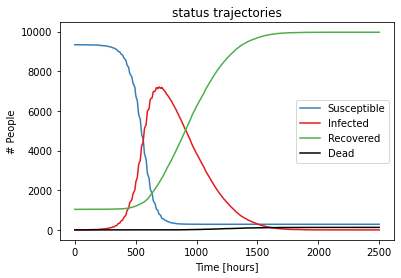

amount of initially recovered agents: 2074
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.2 7899 75 100.0


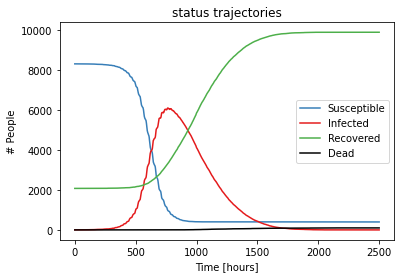

amount of initially recovered agents: 3111
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.30000000000000004 6704 79 111.0


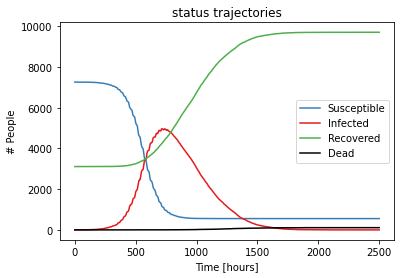

amount of initially recovered agents: 4148
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.4 5236 50 77.0


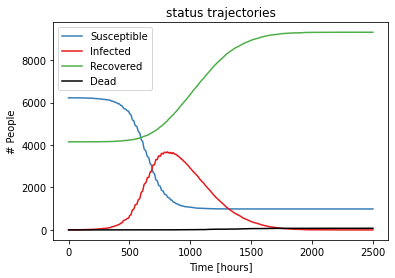

amount of initially recovered agents: 5186
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.5 3911 36 56.0


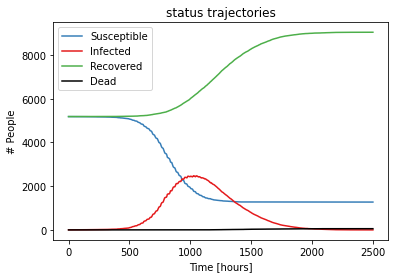

amount of initially recovered agents: 6223
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.6 2966 16 18.0


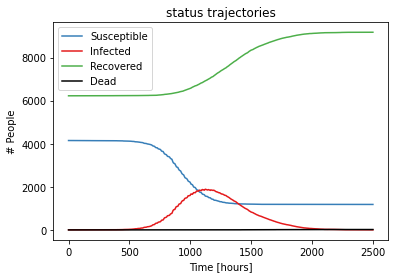

amount of initially recovered agents: 7260
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.7000000000000001 1649 8 16.0


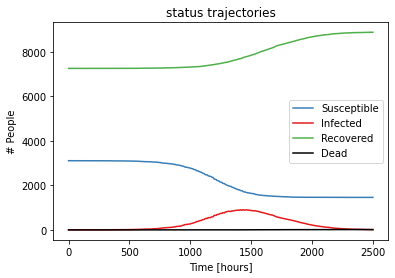

amount of initially recovered agents: 8297
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.8 980 6 3.0


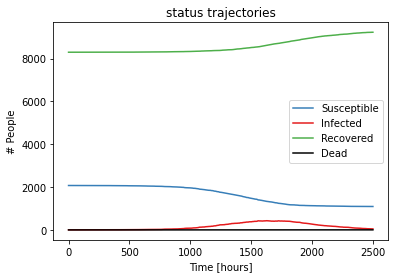

amount of initially recovered agents: 9334
strategy,frac,infected_agents,icued_agents,dead_agents:  interactions_vd 0.9 0 0 0.0


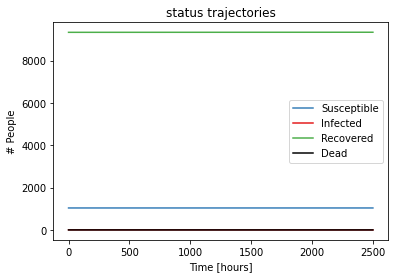

amount of initially recovered agents: 1037
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.1 9078 75 95.0


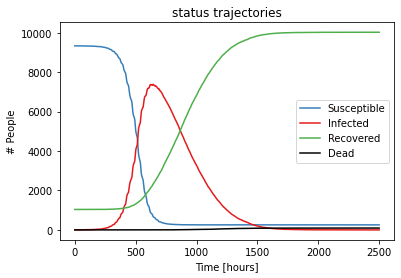

amount of initially recovered agents: 2074
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.2 7981 86 88.0


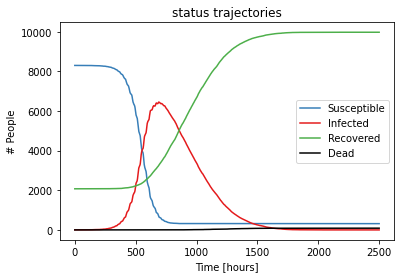

amount of initially recovered agents: 3111
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.30000000000000004 6934 62 41.0


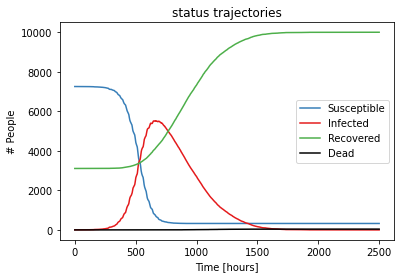

amount of initially recovered agents: 4148
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.4 5865 42 41.0


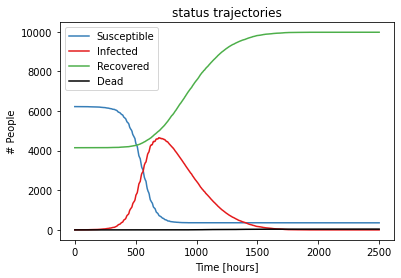

amount of initially recovered agents: 5186
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.5 4796 21 26.0


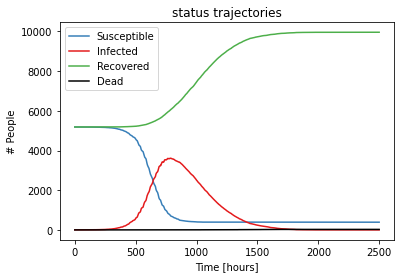

amount of initially recovered agents: 6223
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.6 3674 27 23.0


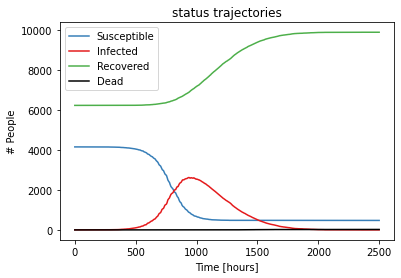

amount of initially recovered agents: 7260
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.7000000000000001 2316 11 17.0


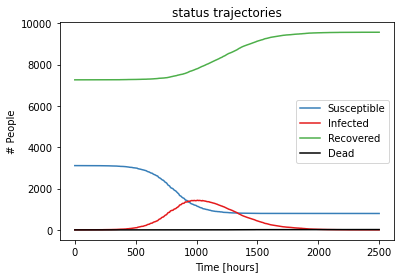

amount of initially recovered agents: 8297
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.8 1000 4 5.0


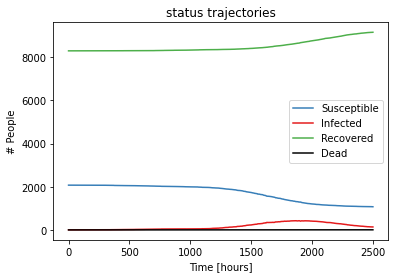

amount of initially recovered agents: 9334
strategy,frac,infected_agents,icued_agents,dead_agents:  households_vd 0.9 1 0 0.0


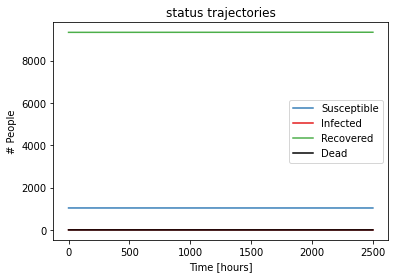

amount of initially recovered agents: 1037
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.1 9194 77 51.0


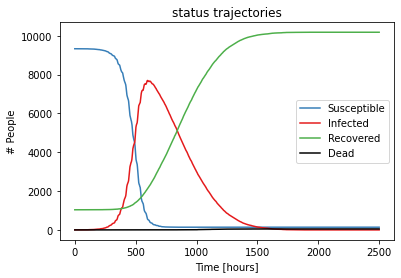

amount of initially recovered agents: 2074
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.2 8133 38 26.0


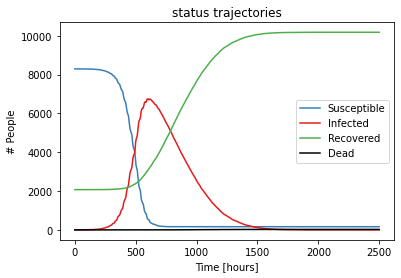

amount of initially recovered agents: 3111
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.30000000000000004 7054 45 21.0


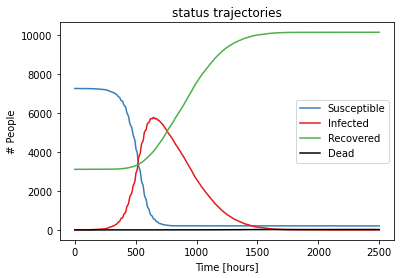

amount of initially recovered agents: 4148
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.4 5947 26 25.0


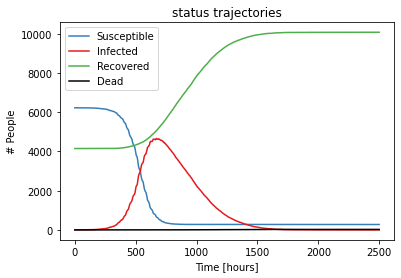

amount of initially recovered agents: 5186
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.5 4812 34 14.0


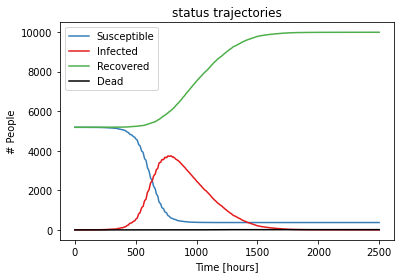

amount of initially recovered agents: 6223
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.6 3675 17 16.0


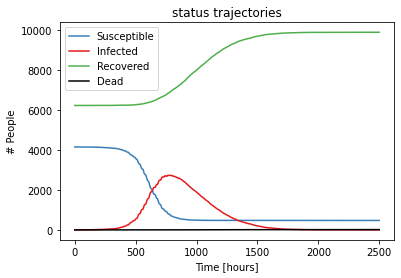

amount of initially recovered agents: 7260
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.7000000000000001 2439 11 7.0


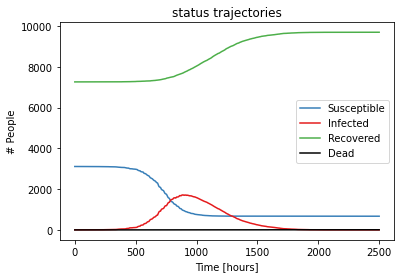

amount of initially recovered agents: 8297
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.8 1 1 1.0


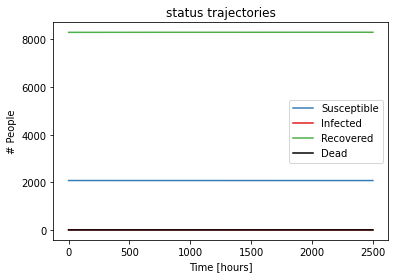

amount of initially recovered agents: 9334
strategy,frac,infected_agents,icued_agents,dead_agents:  age_vd 0.9 7 0 0.0


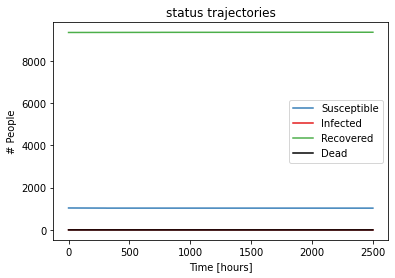

amount of initially recovered agents: 1037
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.1 9035 72 85.0


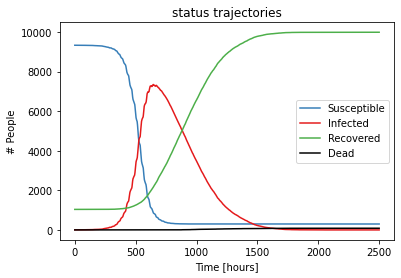

amount of initially recovered agents: 2074
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.2 7952 62 80.0


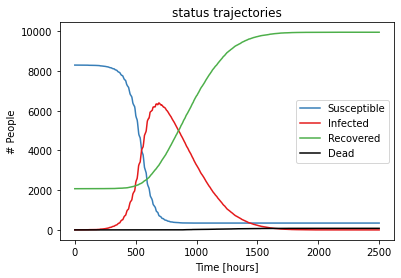

amount of initially recovered agents: 3111
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.30000000000000004 6845 59 56.0


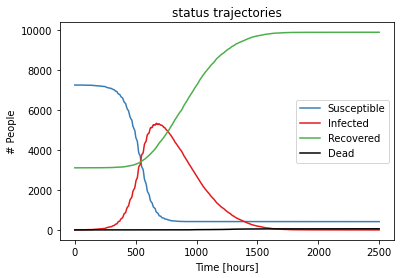

amount of initially recovered agents: 4148
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.4 5735 40 40.0


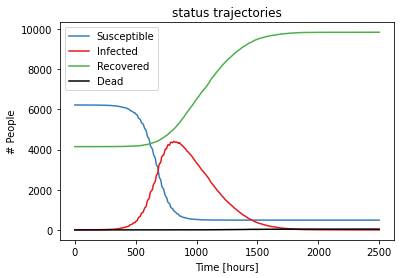

amount of initially recovered agents: 5186
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.5 4522 32 31.0


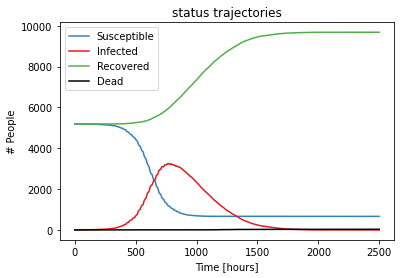

amount of initially recovered agents: 6223
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.6 3401 19 28.0


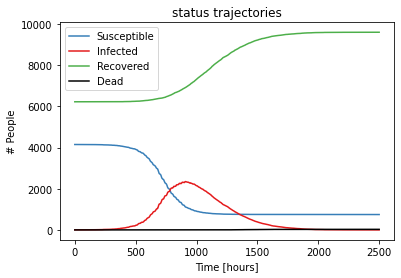

amount of initially recovered agents: 7260
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.7000000000000001 1 0 0.0


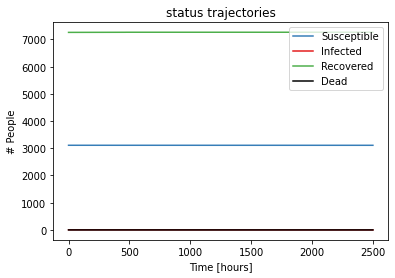

amount of initially recovered agents: 8297
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.8 966 4 4.0


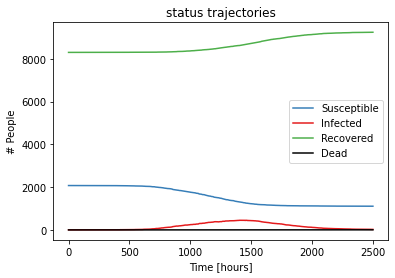

amount of initially recovered agents: 9334
strategy,frac,infected_agents,icued_agents,dead_agents:  random 0.9 0 0 0.0


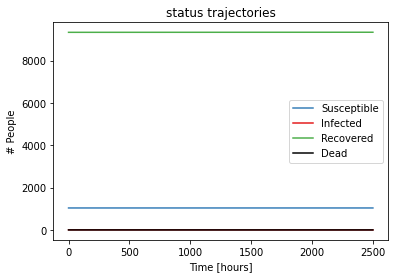

amount of initially recovered agents: 1037
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.1 9169 68 51.0


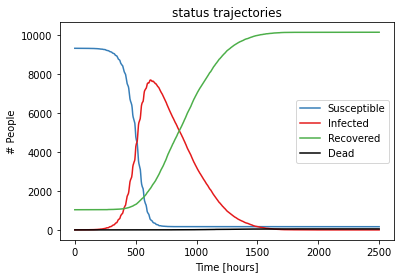

amount of initially recovered agents: 2074
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.2 8158 47 18.0


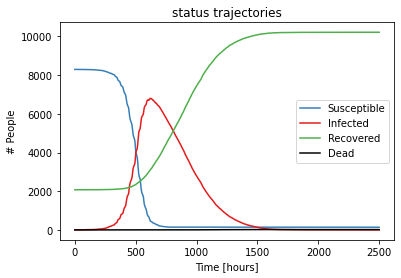

amount of initially recovered agents: 3111
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.30000000000000004 7059 42 22.0


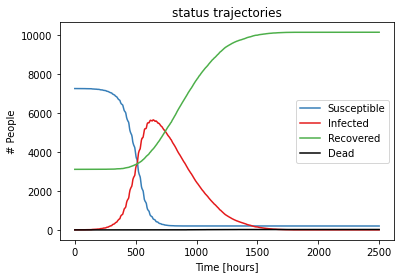

amount of initially recovered agents: 4148
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.4 5930 31 24.0


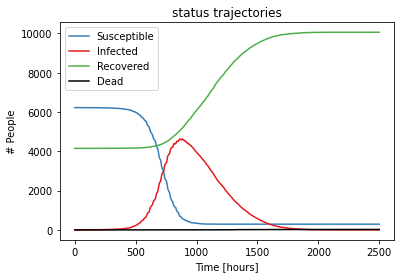

amount of initially recovered agents: 5186
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.5 4706 16 19.0


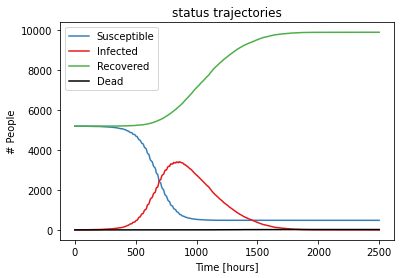

amount of initially recovered agents: 6223
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.6 3381 23 16.0


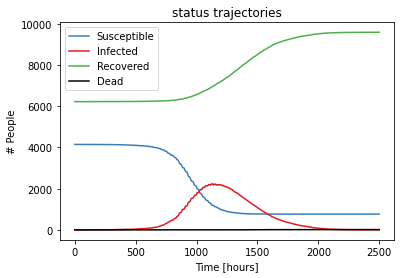

amount of initially recovered agents: 7260
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.7000000000000001 1876 5 3.0


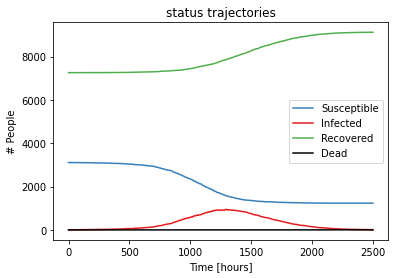

amount of initially recovered agents: 8297
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.8 0 0 0.0


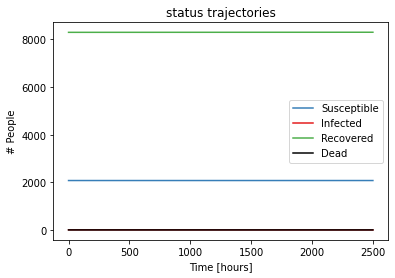

amount of initially recovered agents: 9334
strategy,frac,infected_agents,icued_agents,dead_agents:  old_active_vd 0.9 0 0 0.0


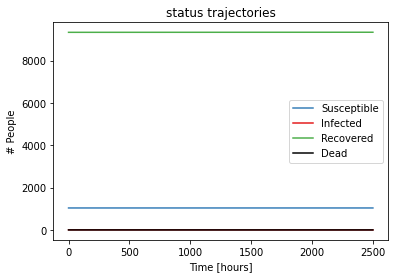

amount of initially recovered agents: 1037
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.1 9004 74 98.0


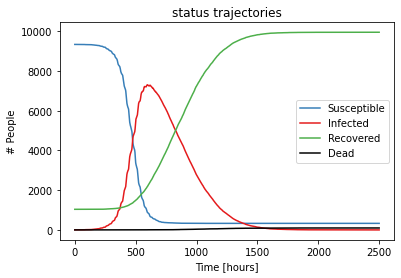

amount of initially recovered agents: 2074
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.2 7895 70 96.0


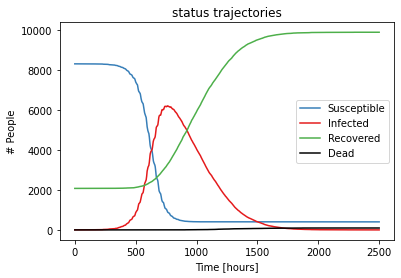

amount of initially recovered agents: 3111
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.30000000000000004 6776 58 66.0


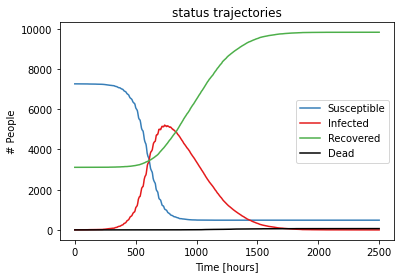

amount of initially recovered agents: 4148
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.4 5565 42 62.0


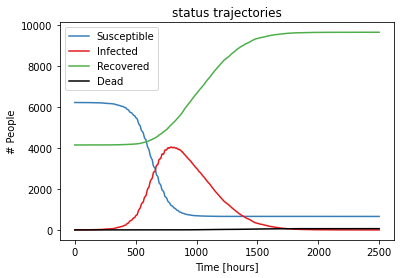

amount of initially recovered agents: 5186
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.5 4340 35 52.0


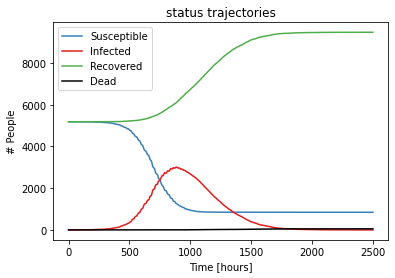

amount of initially recovered agents: 6223
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.6 3149 27 24.0


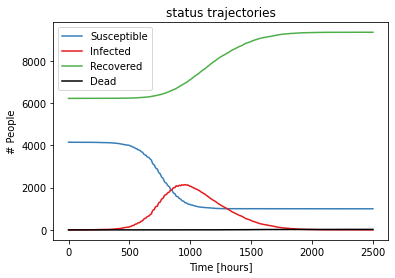

amount of initially recovered agents: 7260
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.7000000000000001 1662 13 9.0


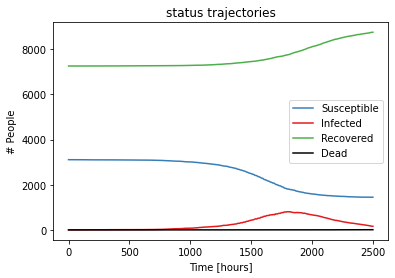

amount of initially recovered agents: 8297
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.8 1031 3 6.0


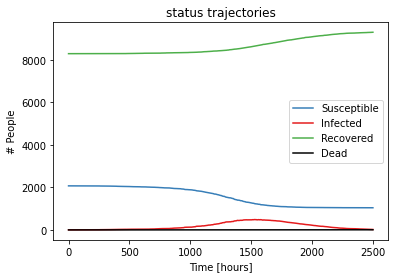

amount of initially recovered agents: 9334
strategy,frac,infected_agents,icued_agents,dead_agents:  forecasted_vd 0.9 0 0 0.0


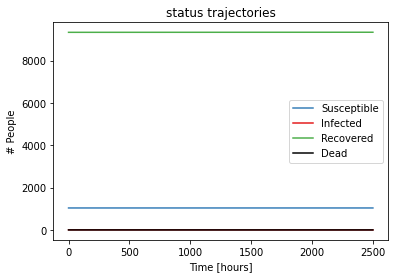

amount of initially recovered agents: 1037
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.1 9017 102 96.0


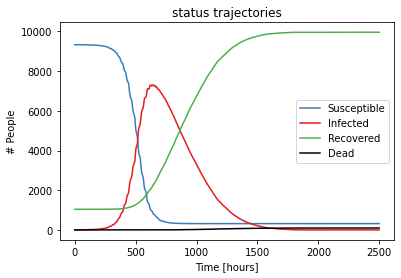

amount of initially recovered agents: 2074
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.2 7930 60 118.0


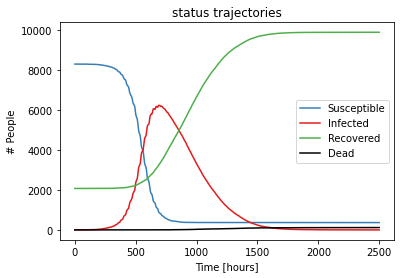

amount of initially recovered agents: 3111
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.30000000000000004 6761 82 106.0


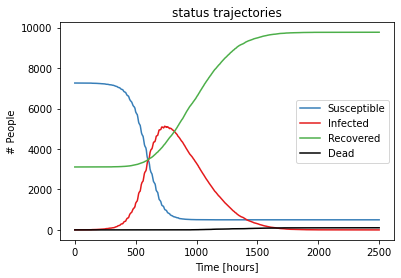

amount of initially recovered agents: 4148
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.4 5652 45 95.0


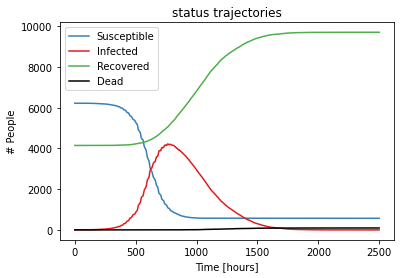

amount of initially recovered agents: 5186
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.5 4317 43 73.0


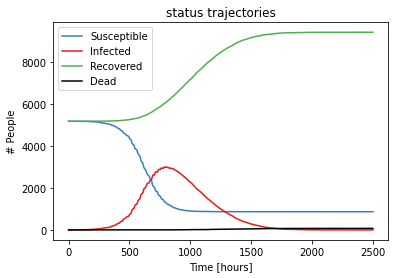

amount of initially recovered agents: 6223
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.6 2822 30 52.0


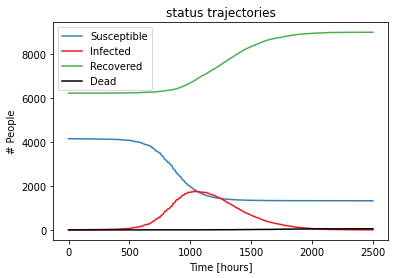

amount of initially recovered agents: 7260
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.7000000000000001 1528 15 19.0


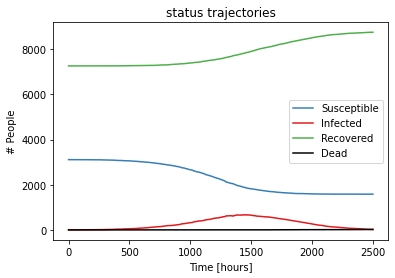

amount of initially recovered agents: 8297
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.8 909 4 4.0


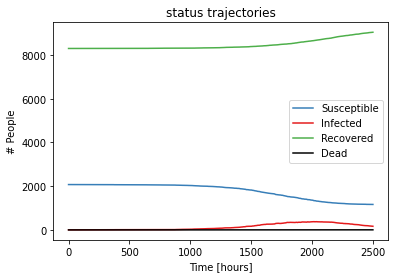

amount of initially recovered agents: 9334
strategy,frac,infected_agents,icued_agents,dead_agents:  overrepresentation_vd 0.9 1 0 0.0


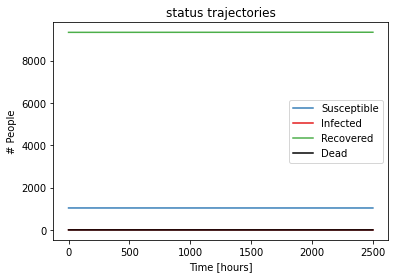

In [34]:
# strategies_to_test = ['forecasted', 'overrepresentation', 'interactions', 'households', 'age', 'random']
# strategies_to_test = ['interactions', 'age', 'random', 'old_active']
# strategies_to_test = ['old_active']
# strategies_to_test = ['forecasted', 'overrepresentation', 'interactions', 'households', 'age', 'random', 'old_active']
# strategies_to_test = ['forecasted', 'overrepresentation', 'interactions', 'households', 'age', 'random', 'old_active', 'forecasted_vd', 'overrepresentation_vd', 'interactions_vd', 'households_vd', 'age_vd', 'old_active_vd']
# strategies_to_test = ['interactions', 'households', 'age', 'random', 'old_active', 'interactions_vd', 'households_vd', 'age_vd', 'old_active_vd']
# strategies_to_test = ['interactions', 'age', 'old_active', 'interactions_vd', 'age_vd', 'old_active_vd', 'interactions_vd1', 'age_vd1', 'old_active_vd1', 'interactions_vd3', 'age_vd3', 'old_active_vd3']
# strategies_to_test = ['interactions', 'age', 'interactions_vd', 'age_vd', 'interactions_vd1', 'age_vd1', 'interactions_vd3', 'age_vd3' ]
strategies_to_test = ['interactions_vd', 'households_vd', 'age_vd', 'random', 'old_active_vd', 'forecasted_vd', 'overrepresentation_vd']
timesteps_vaccination_sim=2500
lowest_vaccination_fraction= 0.10
highest_vaccination_fraction=0.91
increment_size=0.1

fractions = np.arange(lowest_vaccination_fraction, highest_vaccination_fraction, increment_size)

results_dict = {strategy: simulate_fractions(strategy, modeledWorld, agent_orders[strategy], fractions,timesteps_vaccination_sim=timesteps_vaccination_sim) for strategy in strategies_to_test}

# Plot results of vaccination screens<a id='plots'></a>

Here we generate a plot, representing figure 3 in the manuscript. The very left panel corresponds to Panel A in figure 3 and shows the number of total infections, relative to the number of non-vaccinated individuals. The middle panel corresponds to panel 3B, showing the same for deceased individuals. The very right panel corresponds to panel 3D and shows the maximum ICU-demand per 100000. Please note the Panel 3C from the manuscript can not be obtained in this notebook, since it relies on several replicates (100 in our study) of each simulation; and is thus infeasible for demonstration-purposes.

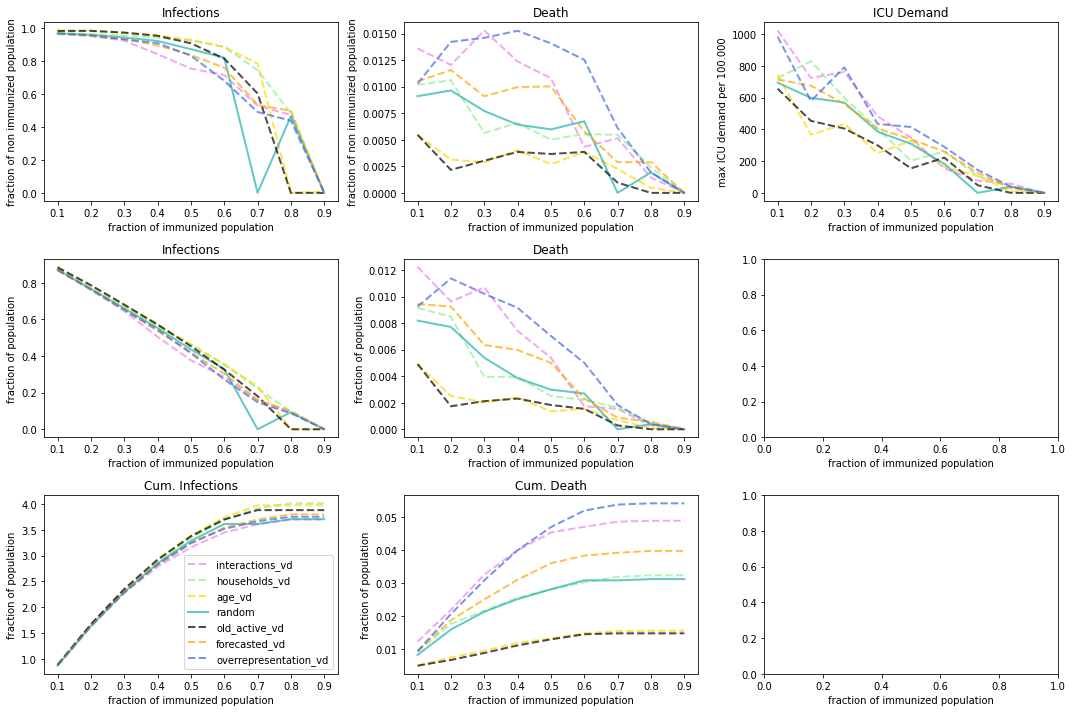

In [35]:
fig, axs = plt.subplots(3,3, figsize=(15,10))


colors = {'random':'lightseagreen', 'interactions':'violet', 'age':'gold', 'old_active':'black',
          'overrepresentation':'royalblue', 'households':'lightgreen', 'forecasted':'orange',
          'interactions_vd':'violet', 'age_vd':'gold', 'old_active_vd':'black',
          'interactions_vd1':'violet', 'age_vd1':'gold', 'old_active_vd1':'black',
          'interactions_vd3':'violet', 'age_vd3':'gold', 'old_active_vd3':'black',
          'overrepresentation_vd':'royalblue', 'households_vd':'lightgreen', 'forecasted_vd':'orange'}
linestyles = {'random':'solid', 'interactions':'solid', 'age':'solid', 'old_active':'solid',
          'overrepresentation':'solid', 'households':'solid', 'forecasted':'solid',
          'interactions_vd1':'dashdot', 'age_vd1':'dashdot', 'old_active_vd1':'dashdot',
          'interactions_vd':'dashed', 'age_vd':'dashed', 'old_active_vd':'dashed',
          'interactions_vd3':'dotted', 'age_vd3':'dotted', 'old_active_vd3':'dotted',
          'overrepresentation_vd':'dashed', 'households_vd':'dashed', 'forecasted_vd':'dashed'}

for strategy in results_dict:
    fractions = results_dict[strategy]['fraction']
    axs[0,0].plot(fractions, results_dict[strategy]['infected']/(modeledWorld.number_of_people*np.clip(1-fractions,0,1)),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy], linestyle=linestyles[strategy])
    axs[0,1].plot(fractions, results_dict[strategy]['dead']/(modeledWorld.number_of_people*np.clip(1-fractions,0,1)),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy], linestyle=linestyles[strategy])
    axs[0,2].plot(fractions, (results_dict[strategy]['icued']/modeledWorld.number_of_people)*100000.0,
                label=strategy, lw=2, alpha=0.7, color=colors[strategy], linestyle=linestyles[strategy])
    axs[1,0].plot(fractions, results_dict[strategy]['infected']/(modeledWorld.number_of_people),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy], linestyle=linestyles[strategy])
    axs[1,1].plot(fractions, results_dict[strategy]['dead']/(modeledWorld.number_of_people),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy], linestyle=linestyles[strategy])
    axs[2,0].plot(fractions, np.cumsum(results_dict[strategy]['infected']/(modeledWorld.number_of_people)),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy], linestyle=linestyles[strategy])
    axs[2,1].plot(fractions, np.cumsum(results_dict[strategy]['dead']/(modeledWorld.number_of_people)),
                label=strategy, lw=2, alpha=0.7, color=colors[strategy], linestyle=linestyles[strategy])
    
    
for ays in axs:
    for ax in ays:
        ax.set_xlabel('fraction of immunized population')
    
axs[0,0].set_ylabel('fraction of non immunized population')
axs[0,1].set_ylabel('fraction of non immunized population')
axs[0,2].set_ylabel('max ICU demand per 100.000')
axs[1,0].set_ylabel('fraction of population')
axs[1,1].set_ylabel('fraction of population')
axs[2,0].set_ylabel('fraction of population')
axs[2,1].set_ylabel('fraction of population')

axs[0,0].set_title('Infections')
axs[0,1].set_title('Death')
axs[0,2].set_title('ICU Demand')
axs[1,0].set_title('Infections')
axs[1,1].set_title('Death')
axs[2,0].set_title('Cum. Infections')
axs[2,1].set_title('Cum. Death')

axs[2,0].legend()

plt.tight_layout()

In [36]:
print('\nage limit: ', old_age_limit)
print('\nmax vacc: ', highest_vaccination_fraction)
for strategy in results_dict:
    print('\n', strategy, '\n', results_dict[strategy], '\n')


age limit:  55

max vacc:  0.91

 interactions_vd 
     fraction infected icued   dead
0.1      0.1     9049   106  127.0
0.2      0.2     7899    75  100.0
0.3      0.3     6704    79  111.0
0.4      0.4     5236    50   77.0
0.5      0.5     3911    36   56.0
0.6      0.6     2966    16   18.0
0.7      0.7     1649     8   16.0
0.8      0.8      980     6    3.0
0.9      0.9        0     0    0.0 


 households_vd 
     fraction infected icued  dead
0.1      0.1     9078    75  95.0
0.2      0.2     7981    86  88.0
0.3      0.3     6934    62  41.0
0.4      0.4     5865    42  41.0
0.5      0.5     4796    21  26.0
0.6      0.6     3674    27  23.0
0.7      0.7     2316    11  17.0
0.8      0.8     1000     4   5.0
0.9      0.9        1     0   0.0 


 age_vd 
     fraction infected icued  dead
0.1      0.1     9194    77  51.0
0.2      0.2     8133    38  26.0
0.3      0.3     7054    45  21.0
0.4      0.4     5947    26  25.0
0.5      0.5     4812    34  14.0
0.6      0.6     367

In [37]:
print(modeledWorld.number_of_people)
# print(len(agents_by_age))
# print(len(agents_by_interactions))
print(len(agents_old_active))

print((time.time()-t0)/3600)

10375
10372
12.818373241027196
